<a href="https://colab.research.google.com/github/gtyellow/SelfDrivingGoKart/blob/main/TrainGokart/Train_gokart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import os

## Keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


#matplotlib for image augmentation and loading image
import matplotlib.image as  mpimg
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

In [ ]:


datadir ='/content/'
columns = ['camera_image', 'steering_angle', 'throttle%']
data_map = pd.read_csv(('/content/results.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:


min_max_df=pd.DataFrame(data=[[data_map['steering_angle'].min(), data_map['throttle%'].min()],
                              [data_map['steering_angle'].max(), data_map['throttle%'].max()]],
                              columns=['steering_angle', 'throttle%'],
                              index=['min','max'])


In [ ]:
print(min_max_df)

     steering_angle  throttle%
min -21.942529       0.5      
max  23.352490       102.5    


In [ ]:
data_map

,camera_image,steering_angle,throttle%
0,0_cam-image_array_.jpg,1.850575,55.1
1,1_cam-image_array_.jpg,1.674330,52.2
2,2_cam-image_array_.jpg,1.850575,46.1
3,3_cam-image_array_.jpg,1.498084,33.2
4,4_cam-image_array_.jpg,1.850575,36.7
...,...,...,...
538,538_cam-image_array_.jpg,7.137931,65.7
539,539_cam-image_array_.jpg,7.137931,59.6
540,540_cam-image_array_.jpg,6.961686,59.6
541,541_cam-image_array_.jpg,7.137931,52.9


In [ ]:
#split into train and test set, 80%
data_map['camera_image']= '/content/'+data_map['camera_image']

x_train, x_test = train_test_split(data_map, test_size = 0.2, shuffle=True)

In [ ]:
#pull out Y values.  These are our dependent variables
Y1_train = np.array(x_train["steering_angle"])
Y2_train = np.array(x_train["throttle%"])

Y1_test = np.array(x_test["steering_angle"])
Y2_test = np.array(x_test["throttle%"])

In [ ]:
#isolate X values.  These are our independet variables, list of images

x_train = x_train.drop(["steering_angle","throttle%"], axis = 1)
x_test = x_test.drop(["steering_angle","throttle%"], axis = 1)



In [ ]:
x_train = np.array(x_train["camera_image"])
x_test = np.array(x_test['camera_image'])

In [ ]:
# augment data.  Basically take our images and increase them by a factor of about 3 for training purposes
# the randomizer line on each transform allows for a 50% chance that each technique
#   will be applied each time

def augmentImage(imgPath, steering_angle):
  img=mpimg.imread(imgPath)

  #pan image
  if np.random.rand()<0.5:
    pan = iaa.Affine(translate_percent={'x':(-0.1,0.1), 'y':(-0.1,0.1)})
    img = pan.augment_image(img)

  #Zoom in on image by 20%
  if np.random.rand()<0.5:
    zoom=iaa.Affine(scale=(1,1.2))
    img= zoom.augment_image(img)

  #increase brightness
  if np.random.rand()<0.5:
    brightness = iaa.Multiply((0.4, 1.2))
    img= brightness.augment_image(img)

  #flip image
  if np.random.rand()<0.5:
    img = cv2.flip(img,1)
    steering_angle=-steering_angle

  return img, steering_angle

In [ ]:
def preProcessing(img):
  
  #crops image, the goal is to get the road and nothing else.  Wil depend on camera placement
  img= img[60:135,:,:]

  #converts to an image that changes colors but helps the computer see lane lines
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  #blurs the image improving model performance
  img =cv2.GaussianBlur(img, (3,3),0)

  #resizes the image as this is what Nvidia trained on
  img=cv2.resize(img, (200, 66))

  #Normalizes image.  Changes color values from 0 to 255 to 0 to 1.  This is to ensure that no
  # large numbers become more important on the model
  img = img/255

  return img



In [ ]:
def batchGen(imagesPath, steeringList, throttleList, batchsize, trainFlag):
  while True:
    imgBatch = []
    steeringBatch = []
    throttleBatch = []

    for i in range(batchsize):
      index= random.randint(0, len(imagesPath)-1)
      if trainFlag:
        img, steering = augmentImage(imagesPath[index], steeringList[index])
      else:
        img=mpimg.imread(imagesPath[index])
        steering=steeringList[index]
      img = preProcessing(img)
      imgBatch.append(img)
      steeringBatch.append(steering)
      throttleBatch.append(throttleList[index])

    yield(np.asarray(imgBatch), [np.asarray(steeringBatch), np.asarray(throttleBatch)])



In [ ]:
#load values into numpy array

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  throttle = []
  for i in range(len(data_map)):
    indexed_data = data_map.iloc[i]
    camera = indexed_data[0]
    image_path.append(os.path.join(datadir, camera.strip()))
    steering.append(float(indexed_data[1]))
    throttle.append(float(indexed_data[2]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  throttles = np.asarray(throttle)
  return image_paths, steerings, throttles

image_paths, steerings, throttles = load_img_steering(datadir, data_map)

In [ ]:
from keras.layers.convolutional.base_separable_conv import Conv
def createModel():
  model = Sequential()

  model.add(Convolution2D(24,(5,5),(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36,(5,5),(2,2), activation='elu'))
  model.add(Convolution2D(48,(5,5),(2,2), activation='elu'))
  model.add(Convolution2D(64,(3,3), activation='elu'))
  model.add(Convolution2D(64,(3,3), activation='elu'))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(2))

  model.compile(Adam(lr=0.001), loss='mse')

  return model



In [ ]:
model=createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit(batchGen(x_train, Y1_train, Y2_train, 10, 1), steps_per_epoch=20, epochs=2,
          validation_data=batchGen(x_test, Y1_test, Y2_test, 10, 0), validation_steps=20)

Epoch 1/2
20/20 [==============================] - 6s 266ms/step - loss: 64.6504 - val_loss: 84.9090
Epoch 2/2
20/20 [==============================] - 5s 253ms/step - loss: 93.3291 - val_loss: 79.1483


In [ ]:
model.save('model_get_the code_right.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

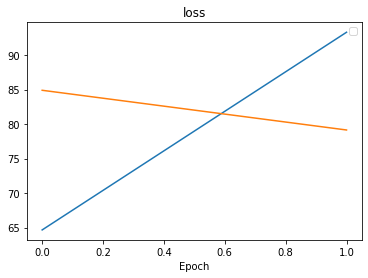

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('Training', 'Validation')

plt.title('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def writepredictimages(image, framecount, predicted_steering, predicted_throttle):
  
  #this stores the images for  later review
  camName=str(framecount) = '_cam_image_array.jpg'
  camPath = os.path.join(data_dir, camName)
  cv2.imwrite(camPath, image)



In [ ]:
cap = cv2.VideoCapture(0)
                       
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

count=0
record_list = []
while(cap.isOpened()):
  ret, frame =cap.read()
  if ret == True:

    img=np.asarray(frame)
    img=preProcessing(img)

    desired_steering, desired_throttle = float(model.predict(image))

    print("Desired steering -> "+ desired_steering, " Desired throttle ->"+ desired_throttle)
    
    # Display the resulting frame
    cv2.imshow('Frame', frame)

    writepredictimages(frame, count)
    count+=1

    

    if cv2.WaitKey(25) & 0xFF == ord('q'):
        break
    # Break the loop
  else: 
    break
 
  